# Train the LSTM-FC baseline with spatial correction

This notebook is for building the LSTM-FC models with the spatial correction. For Google Colab only.

## Set up the environment

### Import the packages

In [ ]:
! pip install geopy
import torch
import torch.nn as nn
import torch.nn.functional as F

import os, sys
import numpy as np

### Training device

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device {device}...')

Using device cuda...


### Saving and loading files to/from different places

- **Temporary files** will be saved in the COLAB workspace directory
- **Models** and other files necessary for long-term use will be saved in the drive directory 

In [ ]:
workspace_dir = '/content'
drive_dir = '/content/drive/Othercomputers/DESKTOP-P14JC7J/2130/code'
sys.path.append(drive_dir)

from data_utils import *

### Copy the processed data here

The processed data should be saved on the Google drive.

In [ ]:
! mkdir data
! mkdir baseline-results
! cp ./drive/MyDrive/urop-paper2-data/* ./data
! cp ./drive/MyDrive/urop-paper2-baseline-results/* ./baseline-results

## Dataset
The dataset used for training and testing.

In [ ]:
from data_utils.obs import ObsReader

from torch.utils.data import Dataset

from datetime import datetime, date, time, timedelta

class BaselineSourceDataset(Dataset):
  def __init__(self, train, device):
    super().__init__()
    self.period = 'train' if train else 'test'
    self.device = device
    self.first_date = eval(f'{self.period}_first_dt').date()
    self.last_date = eval(f'{self.period}_last_dt').date()

    self.obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
    self.wrf_normalizing = np.load(f'{data_dir}/wrf_normalizing.npz')
    self.wrf_normalizing = (self.wrf_normalizing['mean'], self.wrf_normalizing['std'])
    self.cmaq_normalizing = np.load(f'{data_dir}/cmaq_normalizing.npz')
    self.cmaq_normalizing = (self.cmaq_normalizing['mean'], self.cmaq_normalizing['std'])
    
    source_obs_data = load_dict(f'{data_dir}/{self.period}_source_data.pkl')
    source_wrf_match = load_dict(f'{data_dir}/source_wrf_match.pkl')
    source_cmaq_match = load_dict(f'{data_dir}/source_cmaq_match.pkl')
    assert list(source_obs_data.keys()) == list(source_wrf_match.keys()) == list(source_cmaq_match.keys())
    self.source_stations = list(source_obs_data.keys())

    target_obs_data = load_dict(f'{data_dir}/{self.period}_target_data.pkl')

    self.source_obs_reader = ObsReader(source_obs_data)
    self.target_obs_reader = ObsReader(target_obs_data, self.source_stations)

    target_wrf_data = np.load(f'{data_dir}/{self.period}_source_wrf_data.npy')
    target_cmaq_data = np.load(f'{data_dir}/{self.period}_source_cmaq_data.npy')
        
    self.target_wrf_data, self.target_cmaq_data = target_wrf_data, target_cmaq_data

    assert len(self) == self.target_wrf_data.shape[0] == self.target_cmaq_data.shape[0]

  def get_source_obs(self, day0):
    first_dt = datetime.combine(day0-timedelta(days = history_days), time(0))
    last_dt = datetime.combine(day0-timedelta(days = 1), time(23))
    source_obs = self.source_obs_reader(first_dt, last_dt)
    out = {}
    for st, df in source_obs.items():
      means, stds = np.array([self.obs_normalizing[sp][0] for sp in df.columns]), np.array([self.obs_normalizing[sp][1] for sp in df.columns])
      out[st] = torch.nan_to_num(torch.tensor(((df.values - means) / stds).T, dtype = torch.float, device = self.device))
    return out

  def get_target_obs(self, day0):
    means, stds = np.array([self.obs_normalizing[sp][0] for sp in target_species]), np.array([self.obs_normalizing[sp][1] for sp in target_species])
    first_dt = datetime.combine(day0, time(0))
    last_dt = datetime.combine(day0 + timedelta(days = horizon_days - 1), time(23))
    target_obs = self.target_obs_reader(first_dt, last_dt)
    return torch.tensor(np.array([((df.values - means)/stds).T for df in target_obs.values()]), dtype = torch.float, device = self.device)

  def __getitem__(self, index):
    day0 = self.first_date + timedelta(days = history_days + index)

    source_obs = self.get_source_obs(day0)
    target_wrf = torch.tensor((self.target_wrf_data[index] - self.wrf_normalizing[0][:, None])/self.wrf_normalizing[1][:, None], dtype = torch.float, device = self.device)
    target_cmaq = torch.tensor((self.target_cmaq_data[index] - self.cmaq_normalizing[0][:, None])/self.cmaq_normalizing[1][:, None], dtype = torch.float, device = self.device)
    target_wrf_cmaq = torch.cat([target_wrf, target_cmaq], dim = -2)

    target_obs = self.get_target_obs(day0)

    return source_obs, target_wrf_cmaq, target_obs

  def __len__(self):
    return (self.last_date - self.first_date).days - (history_days + horizon_days) + 2

def regional_dataset_collate_fn(batch):
  source_obs_out, target_wrf_cmaq_out, target_obs_out = [], [], []
  for source_obs, target_wrf_cmaq, target_obs in batch:
    source_obs_out.append(source_obs)
    target_wrf_cmaq_out.append(target_wrf_cmaq)
    target_obs_out.append(target_obs)
  return torch.utils.data._utils.collate.default_collate(source_obs_out), torch.stack(target_wrf_cmaq_out, axis = 1), torch.stack(target_obs_out, axis = 1)

## Training
### Hyperparameters
Hyperparameters for training the model and model configurations.

In [ ]:
num_epoch = 32
batch_size = 128
learning_rate, gamma, step_size = 1e-3, 0.9, 100

### Initialization
Build the models, optimizers and learning rate schedulers, and the dataset

In [ ]:
# the model, the optimizer and the scheduler
from baselines.lstm_fc.model import LSTM_FC
models = nn.ModuleDict({st: LSTM_FC(len(df.columns)) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}).to(device)
optimizer = torch.optim.Adam(models.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma = gamma, step_size = step_size)

In [ ]:
from torch.utils.data import DataLoader

# the training set and the distance used
training_set = BaselineSourceDataset(train = True, device = device)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, collate_fn=regional_dataset_collate_fn)

# the validation set and the distance used
validation_set = BaselineSourceDataset(train = False, device = device)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, collate_fn=regional_dataset_collate_fn)

### Training loop

In [ ]:
for i in range(num_epoch):
  models.train()
  train_epoch_loss = 0.0
  for source_obs, target_wrf_cmaq, target_obs in training_loader:
    optimizer.zero_grad()
    out = [models[st](X0, X1) for (st, X0), X1 in zip(source_obs.items(), target_wrf_cmaq)]
    out = torch.stack(out)
    
    mask = ~torch.isnan(target_obs)
    loss = torch.abs(out[mask] - target_obs[mask]).mean()
    with torch.no_grad():
      train_epoch_loss += loss.item() * target_obs.shape[1] / len(training_set)
    loss.backward()
    optimizer.step()
    scheduler.step()

  valid_epoch_loss = 0.0
  models.eval()
  with torch.no_grad():
    for source_obs, target_wrf_cmaq, target_obs in validation_loader:
      out = [models[st](X0, X1) for (st, X0), X1 in zip(source_obs.items(), target_wrf_cmaq)]
      out = torch.stack(out)
      
      mask = ~torch.isnan(target_obs)
      loss = torch.abs(out[mask] - target_obs[mask]).mean()
      valid_epoch_loss += loss.item() * target_obs.shape[1] / len(validation_set)

  print(f'Epoch {i}, training loss {train_epoch_loss:.3g}, validation loss {valid_epoch_loss:.3g}...')
  if train_epoch_loss < valid_epoch_loss:
    break

### Save the trained model

In [ ]:
import json
model_dir = f'{drive_dir}/models/baseline_lstm_fc'
os.makedirs(model_dir, exist_ok = True)
torch.save(models.state_dict(), f'{model_dir}/state_dict')
torch.save(optimizer.state_dict(), f'{model_dir}/optimizer_state_dict')
torch.save(scheduler.state_dict(), f'{model_dir}/scheduler_state_dict')
with open (f'{model_dir}/training_config.json', 'w') as f:
  json.dump({
    'num_epoch': num_epoch, 
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'step_size': step_size
  }, f)

## Prediction
Test on the testing target stations that are neither training target stations nor source stations, report the results on multiple metrics.


### Load the trained model


In [ ]:
from baselines.lstm_fc.model import LSTM_FC
model_dir = f'{drive_dir}/models/baseline_lstm_fc'
models = nn.ModuleDict({st: LSTM_FC(len(df.columns)) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}).to(device)
models.load_state_dict(torch.load(f'{model_dir}/state_dict'))

<All keys matched successfully>

### Load the testing data

In [ ]:
# Only the testing target stations that are neither training target stations nor source stations
source_loc = load_dict(f'{data_dir}/source_loc.pkl')
source_stations = set(source_loc.keys())

train_target_stations = set(load_dict(f'{data_dir}/train_target_loc.pkl').keys())
test_target_loc = load_dict(f'{data_dir}/test_target_loc.pkl')
test_target_stations = set(test_target_loc.keys())

test_target_stations = list(test_target_stations - train_target_stations - source_stations)
test_target_loc = {st: test_target_loc[st] for st in test_target_stations}

In [ ]:
# denormalize the output
obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
means, stds = np.array([obs_normalizing[sp][0] for sp in target_species]), np.array([obs_normalizing[sp][1] for sp in target_species])

In [ ]:
# the testing set
test_batch_size = 128
testing_set = BaselineSourceDataset(train = False, device = device)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=test_batch_size, collate_fn=regional_dataset_collate_fn)

In [ ]:
models.eval()
assert not models.training

In [ ]:
source_pred = {st: [] for st in testing_set.source_stations}
with torch.no_grad():
  testing_loss = 0.0
  for source_obs, target_wrf_cmaq, target_obs in testing_loader:
    assert list(source_obs.keys()) == list(models.keys())
    for (st, model), (st, X0), X1 in zip(models.items(), source_obs.items(), target_wrf_cmaq):
      source_pred[st].append(model.predict(X0, X1, (means, stds)))
for st in testing_set.source_stations:
  source_pred[st] = np.concatenate(source_pred[st])

In [ ]:
target_cmaq_pred = load_dict('baseline-results/cmaq_pred.pkl')

### Interpolation

In [ ]:
! pip install tdqm

# compute (pred - cmaq) at each source station
from data_utils.interpolation import *
source_cmaq_pred = load_dict('baseline-results/source_cmaq_pred.pkl')
source_diff = {st: source_pred[st] - source_cmaq_pred[st] for st in testing_set.source_stations}
assert list(source_diff.keys()) == list(source_loc.keys())

  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1319 sha256=e33c6e3f4656f6c3623f09ab10f5f62b5e5577f20507ca98b99f64771c12ff60
  Stored in directory: /root/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built tdqm


#### Different types of interpolations

##### Nearest Neighbor

In [ ]:
# NN
from data_utils.interpolation import NearestNeighbor as NN 


In [ ]:
nn_interpolation = NN(np.array(list(source_loc.values())), np.array(list(source_diff.values())))
nn_target_diff = {st: arr for st, arr in zip(test_target_loc.keys(), nn_interpolation(np.array(list(test_target_loc.values()))))}
nn_target_pred = {st: target_cmaq_pred[st] + nn_target_diff[st] for st in test_target_stations}
save_dict('baseline-results/sc_NN_pred.pkl', nn_target_pred)

##### Inverse Distance Weighted

In [ ]:
# IDW
from data_utils.interpolation import InverseDistanceWeighted as IDW


In [ ]:
idw_interpolation = IDW(np.array(list(source_loc.values())), np.array(list(source_diff.values())))
idw_target_diff = {st: arr for st, arr in zip(test_target_loc.keys(), idw_interpolation(np.array(list(test_target_loc.values()))))}
idw_target_pred = {st: target_cmaq_pred[st] + idw_target_diff[st] for st in test_target_stations}
save_dict('baseline-results/sc_IDW_pred.pkl', idw_target_pred)

##### Kriging

In [ ]:
# Kriging
! pip install pykrige
from data_utils.interpolation import Interpolation
from pykrige.ok import OrdinaryKriging

class Kriging(Interpolation):
  def __init__(self, lat_lon, values):
    super().__init__(lat_lon, values)

  def interpolate(self, target_lat_lon, z):
    mask = np.isnan(z)
    kriging_instance = OrdinaryKriging(x = self.lat_lon[~mask, 1], y = self.lat_lon[~mask, 0], z = z[~mask], variogram_model='spherical', coordinates_type = 'geographic')
    out, _ = kriging_instance.execute('points', target_lat_lon[:, 1], target_lat_lon[:, 0])
    return out

  Using cached PyKrige-1.6.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (734 kB)


In [ ]:
from tqdm import tqdm

assert(list(test_target_loc.keys()) == test_target_stations)

source_loc_arr = np.array(list(source_loc.values()))
test_target_loc_arr = np.array(list(test_target_loc.values()))
source_diff_arr = np.array(list(source_diff.values()))
kriging_target_diff = {st: [] for st in test_target_stations}

for d in tqdm(range(source_diff_arr.shape[1])):
  day_d_target_diff_arr = Kriging(source_loc_arr, source_diff_arr[:, d])(test_target_loc_arr)
  for st, arr in zip(test_target_stations, day_d_target_diff_arr):
    kriging_target_diff[st].append(arr)

for st in test_target_stations:
  kriging_target_diff[st] = np.stack(kriging_target_diff[st])
kriging_target_pred = {st: target_cmaq_pred[st] + kriging_target_diff[st] for st in test_target_stations}
save_dict('baseline-results/sc_Kriging_pred.pkl', kriging_target_pred)

##### Spline

In [ ]:
from scipy.interpolate import SmoothSphereBivariateSpline
class SphericalSpline(Interpolation):
  @staticmethod
  def to_polar_coords(lat_lon):
    theta, phi = np.pi / 2 - np.deg2rad(lat_lon[:, 0]), np.deg2rad(lat_lon[:, 1])
    return theta, phi
  
  def __init__(self, lat_lon, values):
    super().__init__(lat_lon, values)
  
  def interpolate(self, target_lat_lon, z):
    ss_instance = SmoothSphereBivariateSpline(*SphericalSpline.to_polar_coords(self.lat_lon), z)
    return ss_instance(*SphericalSpline.to_polar_coords(target_lat_lon))

In [ ]:
from tqdm import tqdm

assert(list(test_target_loc.keys()) == test_target_stations)

source_loc_arr = np.array(list(source_loc.values()))
test_target_loc_arr = np.array(list(test_target_loc.values()))
source_diff_arr = np.array(list(source_diff.values()))
target_diff = {st: [] for st in test_target_stations}

for d in tqdm(range(source_diff_arr.shape[1])):
  day_d_target_diff_arr = SphericalSpline(source_loc_arr, source_diff_arr[:, d])(test_target_loc_arr)
  for st, arr in zip(test_target_stations, day_d_target_diff_arr):
    target_diff[st].append(arr)

for st in test_target_stations:
  target_diff[st] = np.stack(target_diff[st])

In [ ]:
for st, arr in target_diff.items():
  print(st, arr.shape)
spline_target_pred = {st: target_cmaq_pred[st] + target_diff[st] for st in test_target_stations}
save_dict('baseline-results/sc_Spline_pred.pkl', spline_target_pred)

##### Save the results

In [ ]:
! cp ./baseline-results/source_sc_*_pred.pkl ./drive/MyDrive/urop-paper2-baseline-results

## Regional forecast

### Data

In [ ]:
! mkdir regional-forecast-data
! cp -r ./drive/MyDrive/urop-paper2-regional-forecast-data/* regional-forecast-data

mkdir: cannot create directory ‘regional-forecast-data’: File exists


In [ ]:
def get_source_diff(_date):
  idx0 = (_date - test_first_dt.date()).days
  idx1 = idx0 - 1

  arr0 = np.array([arr[idx0, :, :24] for arr in source_diff.values()])
  arr1 = np.array([arr[idx1, :, 24:] for arr in source_diff.values()])
  return arr0, arr1 

def get_source_diff_2021_month(m: int):
  date_begin = date(2021, m, 1)
  arr0, arr1 = [], []
  for i in range((date(2021, m + 1, 1) - date(2021, m, 1)).days):
    _date = date_begin + timedelta(days = i)
    _arr0, _arr1 = get_source_diff(_date)
    arr0.append(_arr0)
    arr1.append(_arr1)
  
  arr0, arr1 = np.mean(arr0, axis = (0, 3)), np.mean(arr1, axis = (0, 3))
  return arr0, arr1

_ = get_source_diff_2021_month(11)

In [ ]:
from data_utils.obs import ObsReader

from datetime import datetime, date, time, timedelta

class RegionalForecastDataset:
  def __init__(self, device):
    self.period = 'test'
    self.device = device
    self.first_date = eval(f'{self.period}_first_dt').date()
    self.last_date = eval(f'{self.period}_last_dt').date()

    self.obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
    wrf_normalizing = np.load(f'{data_dir}/wrf_normalizing.npz')
    cmaq_normalizing = np.load(f'{data_dir}/cmaq_normalizing.npz')
    self.wrf_cmaq_normalizing = (np.concatenate([wrf_normalizing['mean'], cmaq_normalizing['mean']]), np.concatenate([wrf_normalizing['std'], cmaq_normalizing['std']]))
    
    source_obs_data = load_dict(f'{data_dir}/{self.period}_source_data.pkl')
    self.source_stations = list(source_obs_data.keys())
    self.source_obs_reader = ObsReader(source_obs_data)

    self.source_loc = load_dict(f'{data_dir}/source_loc.pkl')
    assert list(self.source_loc.keys()) == self.source_stations
    self.grid = np.load('regional-forecast-data/grid.npy')
  
  def get_dist(self):
    source_loc_arr = np.array(list(self.source_loc.values()))
    return torch.tensor(batch_dist(self.grid, source_loc_arr), dtype = torch.float, device = self.device)

  def get_source_obs(self, day0):
    first_dt = datetime.combine(day0-timedelta(days = history_days), time(0))
    last_dt = datetime.combine(day0-timedelta(days = 1), time(23))
    source_obs = self.source_obs_reader(first_dt, last_dt)
    out = {}
    for st, df in source_obs.items():
      means, stds = np.array([self.obs_normalizing[sp][0] for sp in df.columns]), np.array([self.obs_normalizing[sp][1] for sp in df.columns])
      out[st] = torch.nan_to_num(torch.tensor(((df.values - means) / stds).T, dtype = torch.float, device = self.device))
    return out
  
  def get_wrf_cmaq(self, day0):
    wrf_cmaq_results = np.load(f'regional-forecast-data/wrf-cmaq-results/{day0}.npy')
    means, stds = self.wrf_cmaq_normalizing
    out = torch.tensor((wrf_cmaq_results - means[:, None]) / stds[:, None], dtype = torch.float, device = self.device)
    return out

  def __call__(self, day0):
    return self.get_source_obs(day0), self.get_wrf_cmaq(day0)

ds = RegionalForecastDataset(device)

In [ ]:
test_target_data = load_dict(f'{data_dir}/test_target_data.pkl')
test_target_loc = load_dict(f'{data_dir}/test_target_loc.pkl')
assert list(test_target_loc.keys()) == list(test_target_data.keys())

def get_ground_truth(_date):
  first_dt = datetime.combine(_date, time(0))
  last_dt = datetime.combine(_date, time(23))
  return np.array([df.loc[first_dt:last_dt].values.T for st, df in test_target_data.items()])

def get_ground_truth_2021_month(m: int):
  date_begin = date(2021, m, 1)
  out = []
  for i in range((date(2021, m + 1, 1) - date(2021, m, 1)).days):
    _date = date_begin + timedelta(days = i)
    out.append(get_ground_truth(_date)) 

  return np.nanmean(out, axis = (0, 3))

### Model

In [ ]:
from model import Regional
broadcasting = 'Broadcasting'
model_dir = f'{drive_dir}/models/{broadcasting}_model'
regional_model = Regional({st: len(df.columns) for st, df in load_dict(f'{data_dir}/train_source_data.pkl').items()}, broadcasting = broadcasting).to(device).eval()
regional_model.load_state_dict(torch.load(f'{model_dir}/state_dict'))

<All keys matched successfully>

In [ ]:
# denormalize the output
obs_normalizing = load_dict(f'{data_dir}/obs_normalizing.pkl')
means, stds = np.array([obs_normalizing[sp][0] for sp in target_species]), np.array([obs_normalizing[sp][1] for sp in target_species])

### Baselines
#### CMAQ Baseline

In [ ]:
def get_cmaq(pred_date):
  return np.load(f'regional-forecast-data/cmaq-pred/{pred_date}.npy')

def get_cmaq_2021_month(m: int):
  npz_file = np.load(f'regional-forecast-data/cmaq-pred/2021.{m}.npz')
  return npz_file['day0'].mean(axis = -1), npz_file['day1'].mean(axis = -1)

pred_day_0, pred_day_1 = get_cmaq_2021_month(11)
print(pred_day_0.shape, pred_day_1.shape)

(2500, 2) (2500, 2)


### Prediction

In [ ]:
from datetime import date, timedelta

pd = date(2021, 11, 15)

def predict_day_baseline(pred_date, interp_class):
  interp_obj = interp_class(np.array(list(source_latlon.values())), np.array(list(source_diff.values())))


def predict_day(pred_date):
  obs0, wrf_cmaq0 = ds(pred_date)
  obs1, wrf_cmaq1 = ds(pred_date - timedelta(days = 1))
  dist = ds.get_dist()
  pred0 = regional_model.predict(obs0, wrf_cmaq0, dist, (means, stds))[:, :, :24]
  pred1 = regional_model.predict(obs1, wrf_cmaq1, dist, (means, stds))[:, :, 24:]
  return pred0, pred1

def predict_2021_month(m: int):
  date_begin = date(2021, m, 1)
  month_pred_0, month_pred_1 = [], []
  for i in range((date(2021, m + 1, 1) - date(2021, m, 1)).days):
    pred_date = date_begin + timedelta(days = i)
    pred0, pred1 = predict_day(pred_date)
    month_pred_0.append(pred0)
    month_pred_1.append(pred1)
  
  month_pred_0, month_pred_1 = np.mean(month_pred_0, axis = 0), np.mean(month_pred_1, axis = 0)
  return month_pred_0.mean(axis = -1), month_pred_1.mean(axis = -1)

#### Visualize

In [ ]:
gt_Y, gt_X = np.array(list(test_target_loc.values())).T

In [ ]:
import matplotlib.pyplot as plt
from regional_forecast import *
from data_utils.plot_stations import *
X, Y = lon_grid, lat_grid

regional_cmap = 'YlGnBu'

def plot_2021_month (mth: int):

  ground_truth = get_ground_truth_2021_month(mth)

  borders = get_border(f'{data_dir}/pearl_delta.txt', (21.6, 24.5), (111.2, 115.6))

  fig, axes = plt.subplots(4, 5, figsize = (30, 20), sharex = True, sharey = True, constrained_layout = True)

  plotted_values = np.zeros((4, 5, len(lat_range), len(lon_range)))

  # cmaq prediction
  cmaq_pred = get_cmaq_2021_month(mth)
  for i, sp in enumerate(target_species):
    for j in range(horizon_days):
      Z = cmaq_pred[j][:, i].reshape(len(lat_range), len(lon_range))

      plotted_values[2 * i + j, 0] = Z

  assert list(source_loc.keys()) == list(source_diff.keys())

  for k, interp_class in zip(range(1, 4), [NN, IDW, Kriging]):
    interp_objs = [interp_class(np.array(list(source_loc.values())), diff_arr) for diff_arr in get_source_diff_2021_month(mth)] 
    regional_diffs = [iobj(np.stack([Y, X], axis = -1)) for iobj in interp_objs]
    for i, sp in enumerate(target_species):
      for j in range(horizon_days):
        Z = plotted_values[2 * i + j, 0] + regional_diffs[j][:, :, i]

        plotted_values[2 * i + j, k] = Z

  # model prediction
  model_predict = predict_2021_month(mth)
  for i, sp in enumerate(target_species):
    for j in range(horizon_days):
      Z = model_predict[j][:, i].reshape(len(lat_range), len(lon_range))

      plotted_values[2 * i + j, 4] = Z

  
  colorbar_range = ((np.quantile(plotted_values[:2], 0.05), np.quantile(plotted_values[:2], 0.95)), 
                    (np.quantile(plotted_values[2:], 0.05), np.quantile(plotted_values[2:], 0.95)))
  colorbars = [None, None]
  for i in range(4):
    cb_min, cb_max = colorbar_range[i // 2]
    for j, ax in enumerate(axes[i]):
      colorbars[i // 2] = ax.pcolormesh(X, Y, plotted_values[i, j], vmin = cb_min, vmax = cb_max, cmap = regional_cmap)
      colorbars[i // 2] = ax.scatter(gt_X, gt_Y, c = ground_truth[:, i // 2], vmin = cb_min, vmax = cb_max, cmap = regional_cmap, edgecolors= "black")
      for section in borders:
        ax.plot(*section, 'k', linewidth = 1)
      ax.xaxis.set_tick_params(labelsize = 10)
      ax.yaxis.set_tick_params(labelsize = 10)
  
  for i, u in enumerate(['$\mu$g/m$^3$', 'ppbv']):
    cbar = plt.colorbar(colorbars[i], ax=axes[2 * i: 2 * i + 2].ravel().tolist())
    cbar.set_label(label=u, size=15)
    cbar.ax.tick_params(labelsize=10)

  for ax, col_name in zip(axes[0], ['CMAQ', 'SC (NN)', 'SC (IDW)', 'SC (Kriging)', 'Broadcasting']):
    ax.set_title(col_name, fontsize = 20)

  for ax, row_name in zip(axes[:,0], ['PM$_{2.5}$, 0-23 h', 'PM$_{2.5}$, 24-47 h', 'O$_3$, 0-23 h', 'O$_3$, 24-47 h']):
    ax.set_ylabel(row_name, rotation=90, fontsize = 20)

  



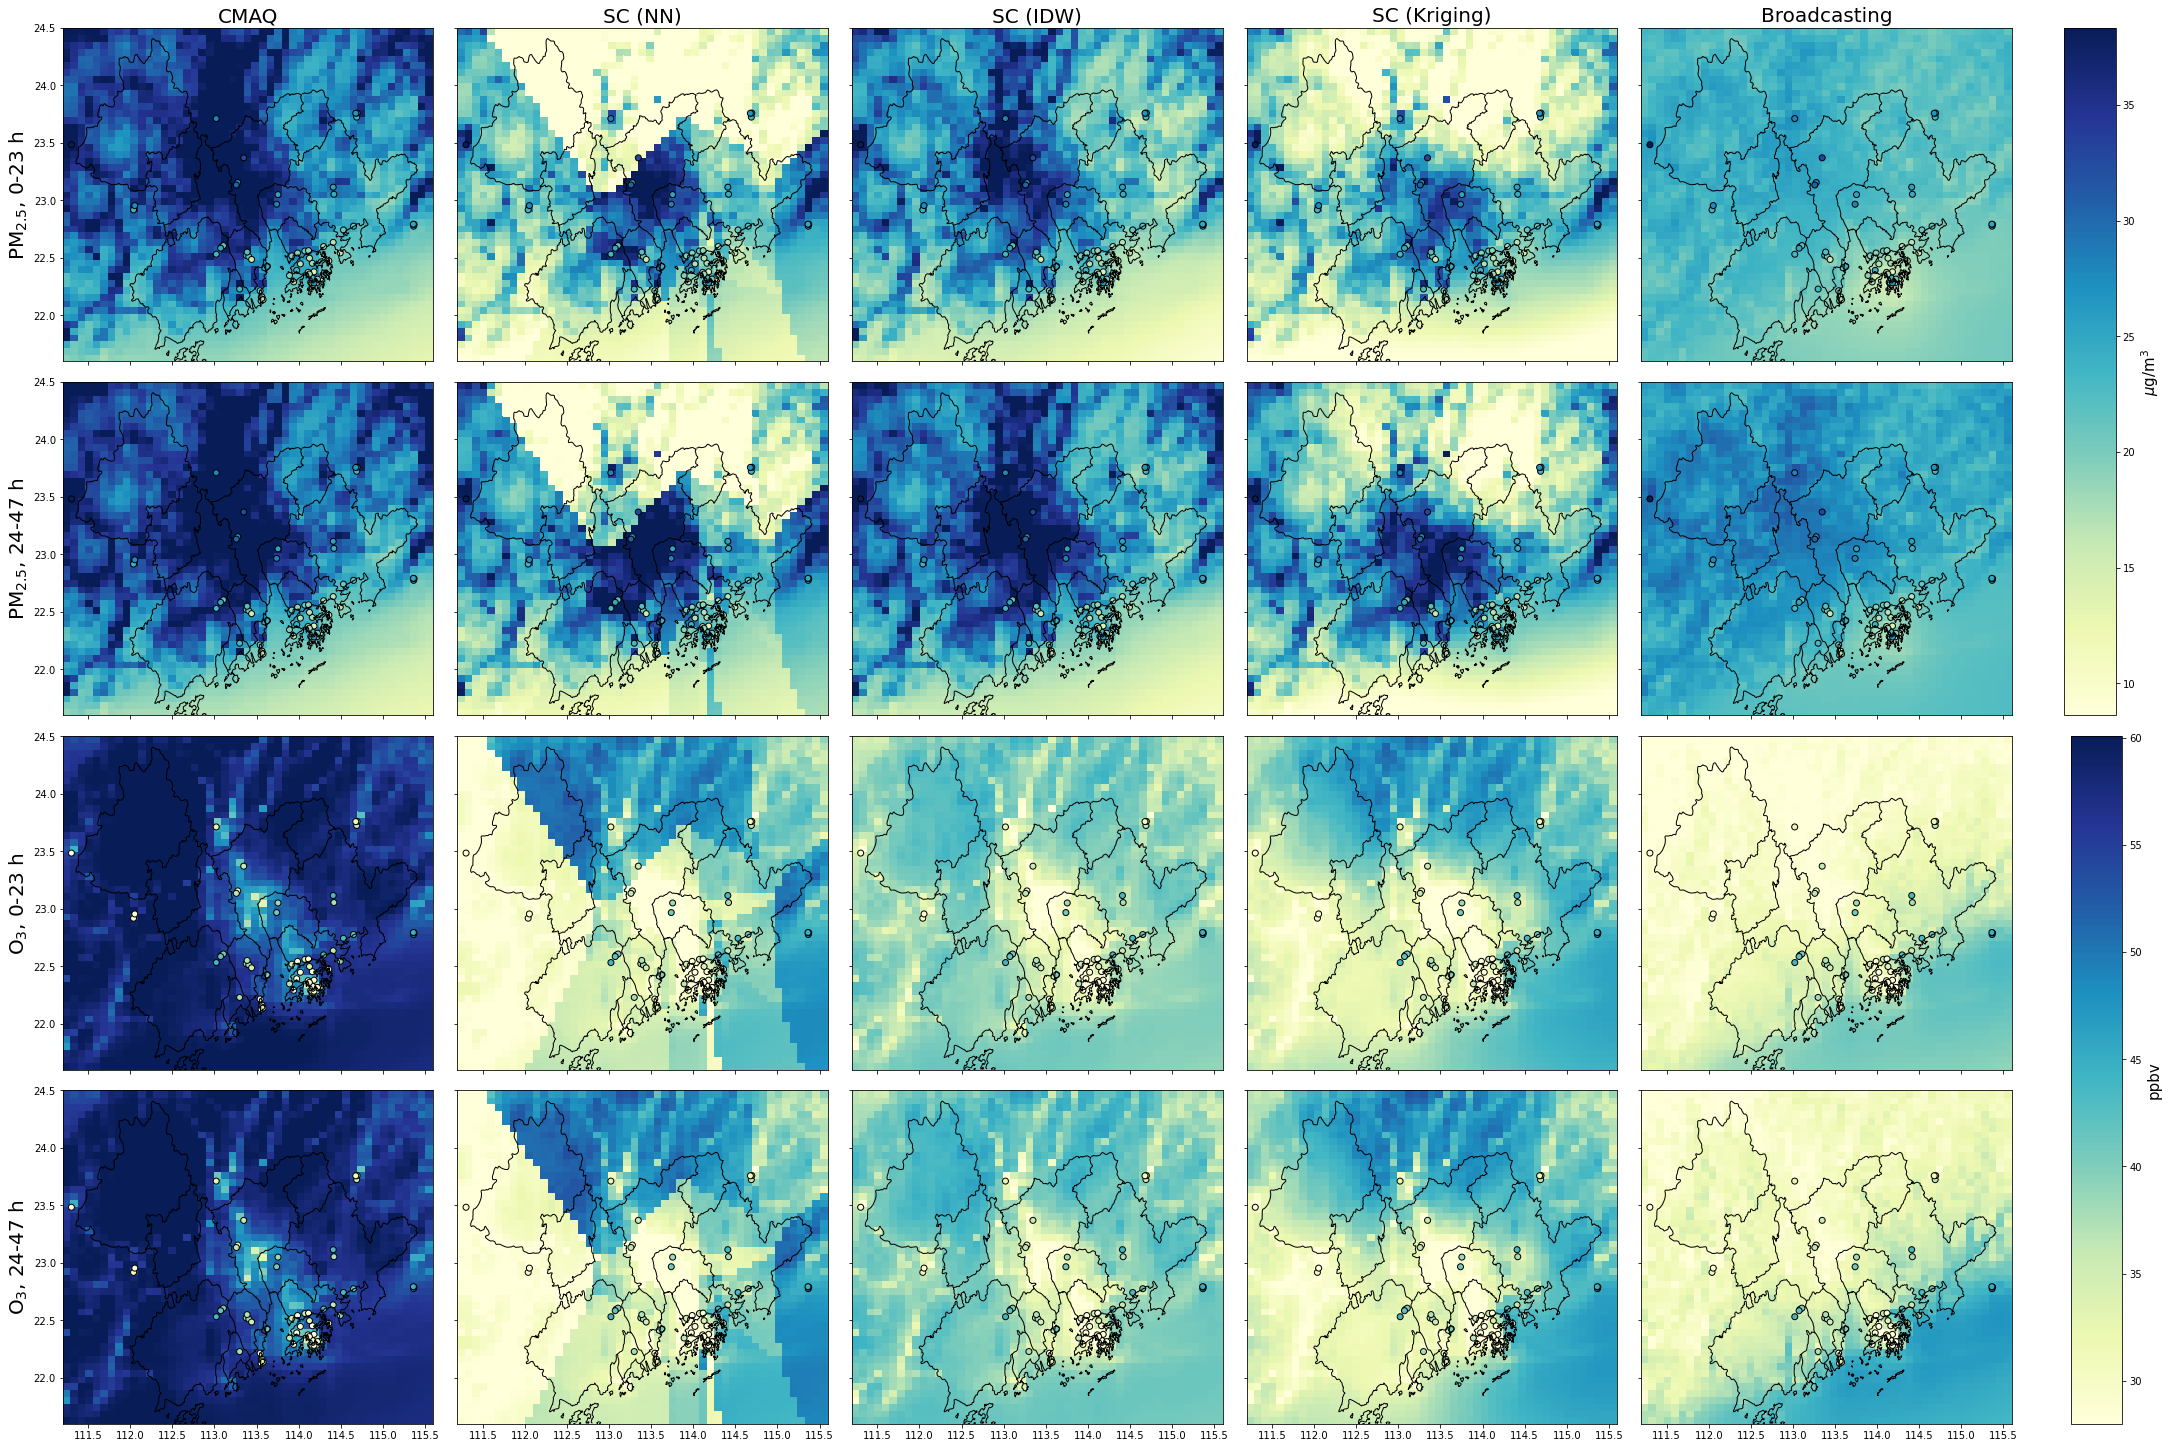

In [ ]:
plot_2021_month(2)

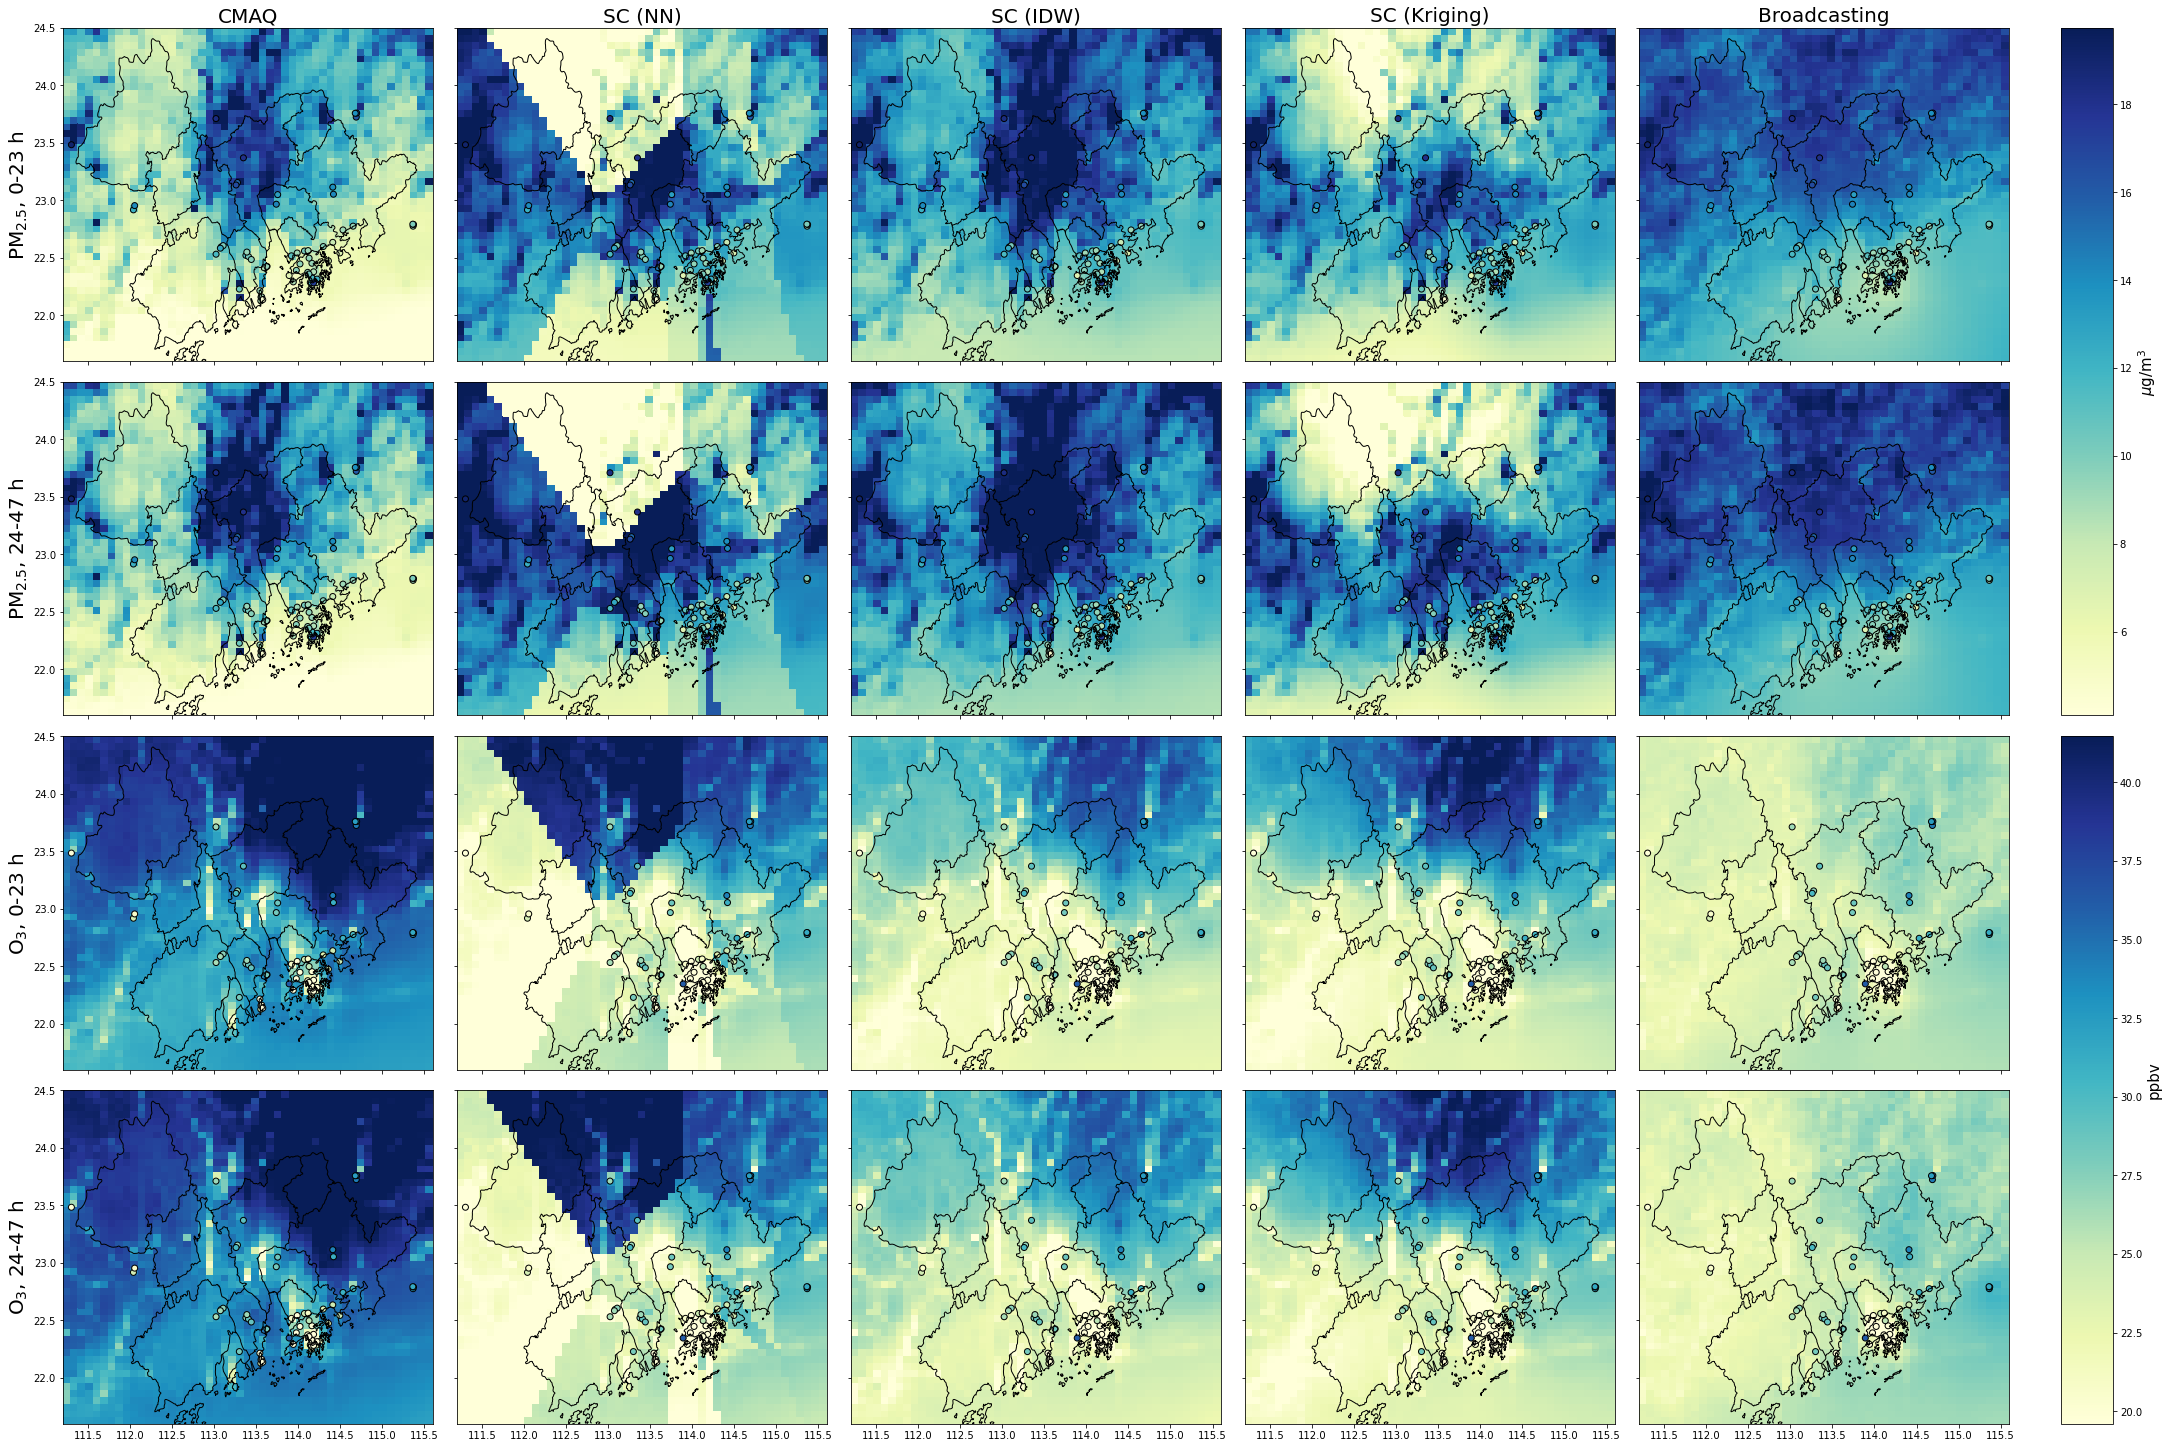

In [ ]:
plot_2021_month(5)

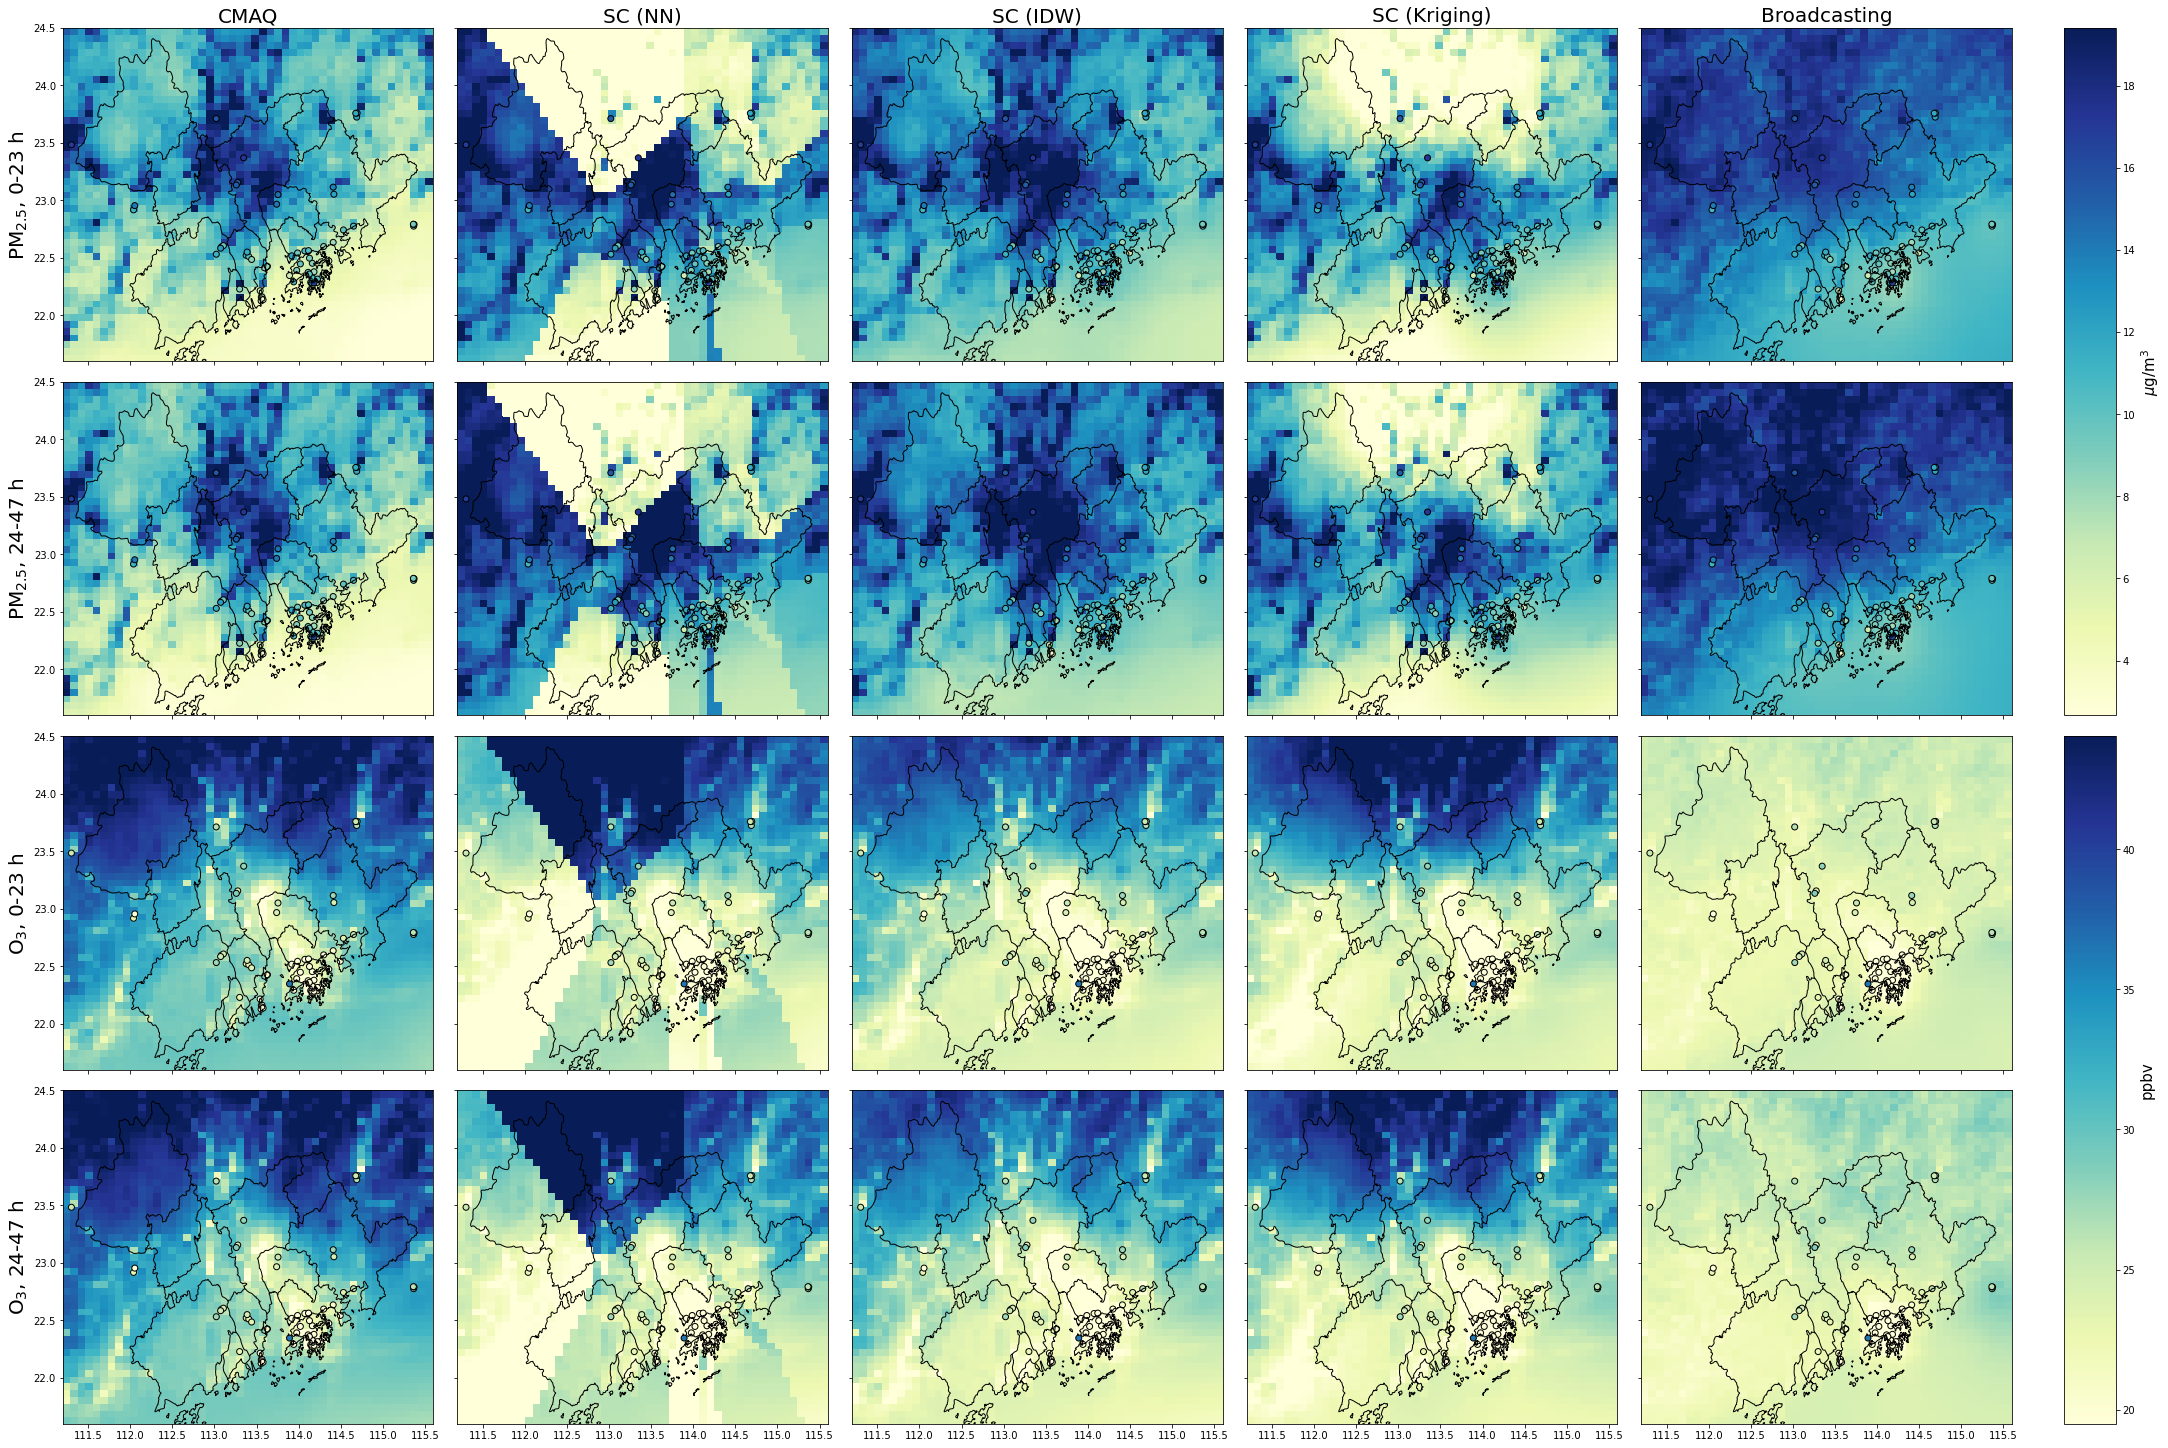

In [ ]:
plot_2021_month(8)

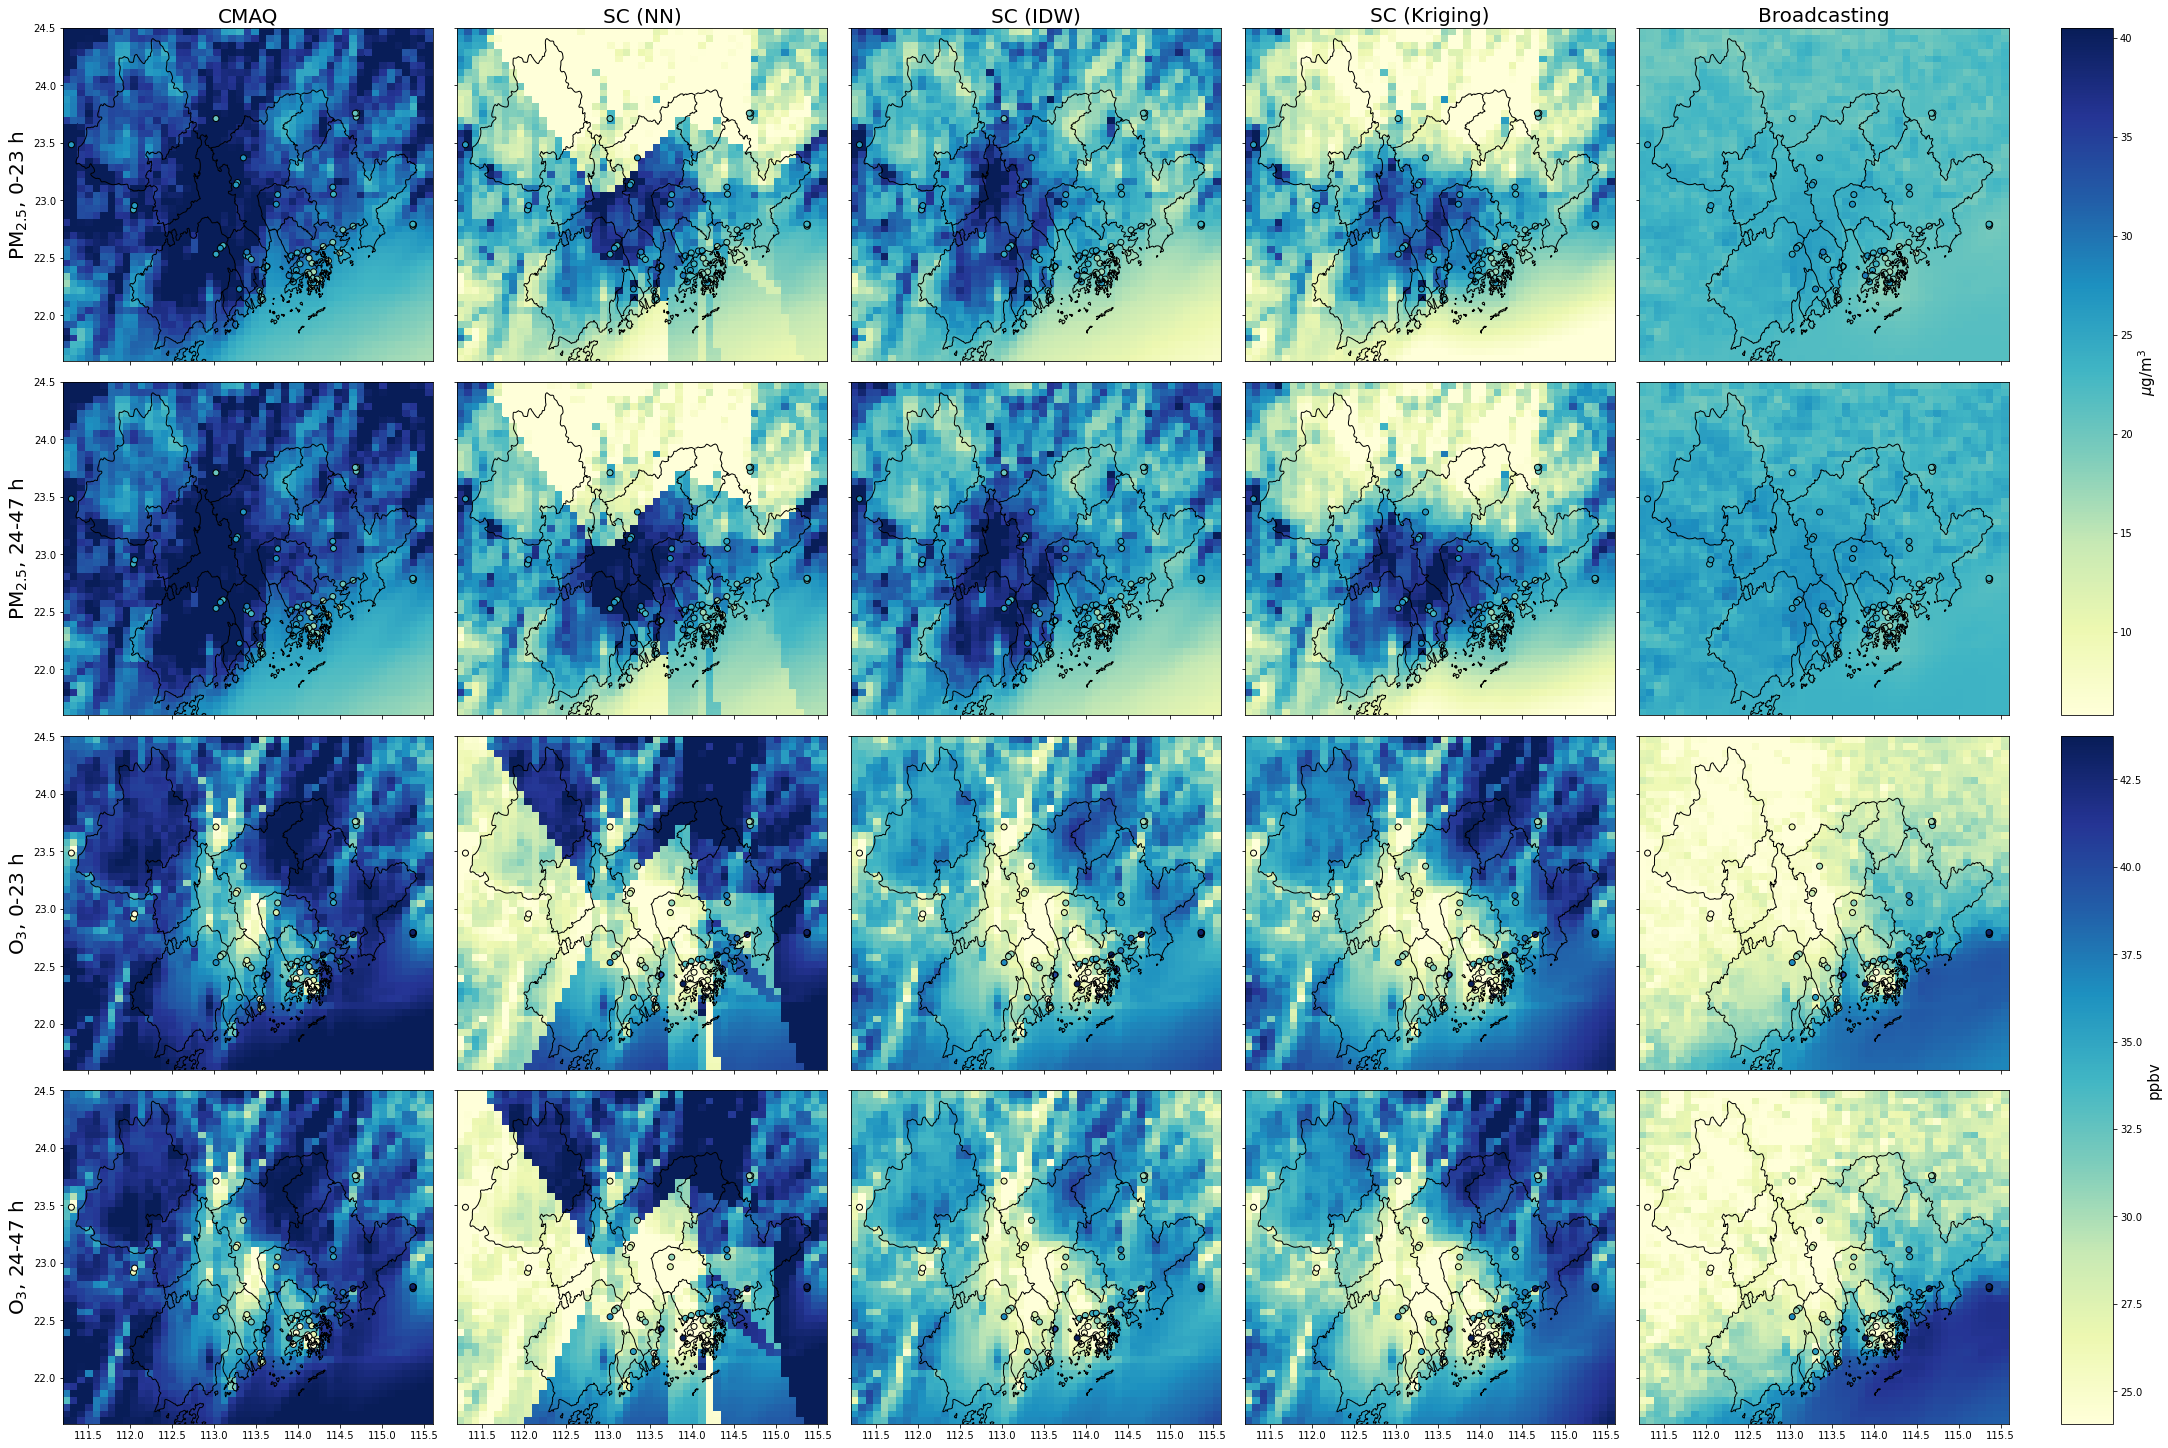

In [ ]:
plot_2021_month(11)